In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from ptflops import get_model_complexity_info

from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader
from utils.Trainer import ModelTrainer

device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
class BasicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BasicLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size*4)
        self.Drop = nn.Dropout(0.3)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.Drop(out)
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 4, self.output_size)  # reshape the output to [batch_size, output_size, 4]
        out = out.permute(0, 2, 1)
        
        return out

In [16]:
class EMG_dataset(torch.utils.data.Dataset):
    def __init__(self, csv, lag, n_ahead):
        self.csv = csv
        self.lag = lag
        self.n_ahead = n_ahead

    def __len__(self):
        return len(self.csv) - self.lag - self.n_ahead

    def __getitem__(self, idx):
        X = self.csv.iloc[idx:idx+self.lag, :4].values
        Y = self.csv.iloc[idx+self.lag:idx+self.lag+self.n_ahead, 4:].values
        
        return (torch.Tensor(X), torch.Tensor(Y))

In [17]:
def train_test_model(model, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=False):
    Trainer = ModelTrainer(model, nn.MSELoss(), torch.optim.Adam(model.parameters(), lr=lr), nn.MSELoss(), "Regression",  device, 0, noPrint=noPrint)
    t0 = datetime.now()
    Trainer.fit(trainLoader, validateLoader, EPOCHS)
    t1 = datetime.now()
    Trainer.Test_Model(testLoader)
    
    if not noPrint:
        print("\nTest Loss:", Trainer.Metrics["Test Loss"], "\nTime to Train:", t1 - t0)
        Trainer.Graph_Metrics()
    
    macs, params = get_model_complexity_info(Trainer.model, (24, 4), as_strings=True, print_per_layer_stat=False, verbose=True)
    Trainer.model.to("cpu")
    
    return Trainer, (macs, params)

,L_Quad: EMG 1 (IM) [V],L_Hamstring: EMG 2 (IM) [V],L_AntTib: EMG 3 (IM) [V],L_Calf: EMG 4 (IM) [V],R_Quad: EMG 5 (IM) [V],R_Hamstring: EMG 6 (IM) [V],R_AntTib: EMG 7 (IM) [V],R_Calf: EMG 8 (IM) [V]
0,0.111732,0.002260,0.111354,0.095514,0.082478,0.034568,0.014811,0.107523
1,0.106569,0.174243,0.440934,0.071500,0.120523,0.323094,0.035016,0.276876
2,0.085491,0.366960,0.077289,0.020765,0.142317,0.102857,0.052945,0.009403
3,0.099687,0.206314,0.367075,0.150406,0.181044,0.076396,0.017372,0.231190
4,0.006346,0.057149,0.011427,0.020112,0.161338,0.155786,0.071158,0.202951
...,...,...,...,...,...,...,...,...
3577,0.021143,0.145937,0.032054,0.004480,0.068054,0.466617,0.049029,0.071574
3578,0.000854,0.250712,0.057858,0.126241,0.016629,0.378969,0.034104,0.033434
3579,0.050638,0.073593,0.016769,0.033509,1.000000,0.156686,0.072951,0.065664
3580,0.059347,0.068247,0.024320,0.084355,0.176838,0.015171,0.037211,0.136361


torch.Size([12, 24, 4]) torch.Size([12, 12, 4])


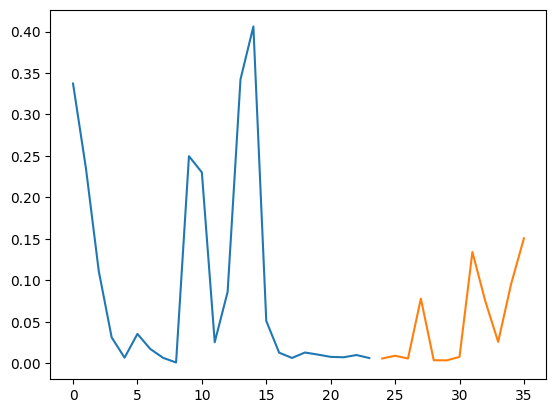

In [18]:
total = pd.read_csv("datasets/processed/total.csv").fillna(0, inplace=False)
display(total)

dataset = EMG_dataset(total, lag=24, n_ahead=12)

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
trainLoader = DataLoader(train_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=False)
validLoader = DataLoader(valid_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=True)

for X, Y in trainLoader:
    print(X.shape, Y.shape)
    
    # Assume Extension 
    y_range = range(len(X[0]), len(X[0])+validLoader.dataset.dataset.n_ahead)
    
    # First Batch
    plt.plot(X[0][:,0])
    plt.plot(y_range, Y[0][:,0])
    break

In [6]:
def test_parameters(EPOCHS=100, lr=0.001):
    
    dataset = EMG_dataset(total, lag=24, n_ahead=12)

    train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
    
    
    input_size = 4
    hidden_sizes = [64, 96, 128]
    num_layers = [3, 4, 5]
    batch_sizes = [2, 3, 4]
    output_size = train_dataset.dataset.n_ahead
    
    results = []
    trainers = []
    
    for hidden_size in hidden_sizes:
        for num_layer in num_layers:
            for batch_size in batch_sizes:
            
                trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
                validLoader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
                testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

                model = BasicLSTM(input_size, hidden_size, num_layer, output_size)

                Trainer, mp = train_test_model(model, lr, trainLoader, validLoader, testLoader, EPOCHS, noPrint=True)
                trainers.append(Trainer)
                
                test_loss = Trainer.Metrics["Test Loss"]
                results.append(f"Hidden: {hidden_size} | Layers: {num_layer} | Batch Size: {batch_size} | Macs: {mp[0]} | Params: {mp[1]} | Test Loss: {test_loss}")
                print(results[-1])
                               
    results = np.array(results)
    
    return results, trainers

In [11]:
re, T = test_parameters(200)

Hidden: 64 | Layers: 3 | Batch Size: 2 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.03852829836886114
Hidden: 64 | Layers: 3 | Batch Size: 3 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05379110254064391
Hidden: 64 | Layers: 3 | Batch Size: 4 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05771690192684699
Hidden: 64 | Layers: 4 | Batch Size: 2 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.027474510929429194
Hidden: 64 | Layers: 4 | Batch Size: 3 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.0301073888780447
Hidden: 64 | Layers: 4 | Batch Size: 4 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.03353911740810014
Hidden: 64 | Layers: 5 | Batch Size: 2 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19420315852047693
Hidden: 64 | Layers: 5 | Batch Size: 3 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19426139073155602
Hidden: 64 | Layers: 5 | Batch Size: 4 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.027084436435043144
Hidden: 96 | Layers: 3 | Ba

Hidden: 64 | Layers: 2 | Batch Size: 4 | Macs: 1.26 MMac | Params: 54.32 k | Test Loss: 0.06733934581279755
Hidden: 64 | Layers: 2 | Batch Size: 16 | Macs: 1.26 MMac | Params: 54.32 k | Test Loss: 0.0748613253235817
Hidden: 64 | Layers: 2 | Batch Size: 32 | Macs: 1.26 MMac | Params: 54.32 k | Test Loss: 0.08276855945587158
Hidden: 64 | Layers: 4 | Batch Size: 4 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.05407020077109337
Hidden: 64 | Layers: 4 | Batch Size: 16 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.0663127526640892
Hidden: 64 | Layers: 4 | Batch Size: 32 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.07040233165025711
Hidden: 64 | Layers: 6 | Batch Size: 4 | Macs: 4.52 MMac | Params: 187.44 k | Test Loss: 0.07566986978054047
Hidden: 64 | Layers: 6 | Batch Size: 16 | Macs: 4.52 MMac | Params: 187.44 k | Test Loss: 0.19122886657714844
Hidden: 64 | Layers: 6 | Batch Size: 32 | Macs: 4.52 MMac | Params: 187.44 k | Test Loss: 0.06731513887643814
Hidden: 128 | Layers: 2 | Batch Size: 4 | Macs: 4.88 MMac | Params: 206.9 k | Test Loss: 0.04985114932060242
Hidden: 128 | Layers: 2 | Batch Size: 16 | Macs: 4.88 MMac | Params: 206.9 k | Test Loss: 0.05833622068166733
Hidden: 128 | Layers: 2 | Batch Size: 32 | Macs: 4.88 MMac | Params: 206.9 k | Test Loss: 0.06787940114736557
Hidden: 128 | Layers: 4 | Batch Size: 4 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.02661198005080223
Hidden: 128 | Layers: 4 | Batch Size: 16 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.04889538139104843
Hidden: 128 | Layers: 4 | Batch Size: 32 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.05771384760737419
Hidden: 128 | Layers: 6 | Batch Size: 4 | Macs: 17.69 MMac | Params: 735.28 k | Test Loss: 0.19148249924182892
Hidden: 128 | Layers: 6 | Batch Size: 16 | Macs: 17.69 MMac | Params: 735.28 k | Test Loss: 0.19151681661605835
Hidden: 128 | Layers: 6 | Batch Size: 32 | Macs: 17.69 MMac | Params: 735.28 k | Test Loss: 0.05349093675613403
Hidden: 256 | Layers: 2 | Batch Size: 4 | Macs: 19.21 MMac | Params: 806.96 k | Test Loss: 0.024070965126156807
Hidden: 256 | Layers: 2 | Batch Size: 16 | Macs: 19.21 MMac | Params: 806.96 k | Test Loss: 0.046882450580596924
Hidden: 256 | Layers: 2 | Batch Size: 32 | Macs: 19.21 MMac | Params: 806.96 k | Test Loss: 0.05703727528452873
Hidden: 256 | Layers: 4 | Batch Size: 4 | Macs: 44.59 MMac | Params: 1.86 M | Test Loss: 0.014045578427612782
Hidden: 256 | Layers: 4 | Batch Size: 16 | Macs: 44.59 MMac | Params: 1.86 M | Test Loss: 0.03199911490082741
Hidden: 256 | Layers: 4 | Batch Size: 32 | Macs: 44.59 MMac | Params: 1.86 M | Test Loss: 0.05679785832762718
Hidden: 256 | Layers: 6 | Batch Size: 4 | Macs: 69.98 MMac | Params: 2.91 M | Test Loss: 0.01443294994533062
Hidden: 256 | Layers: 6 | Batch Size: 16 | Macs: 69.98 MMac | Params: 2.91 M | Test Loss: 0.19122442603111267
Hidden: 256 | Layers: 6 | Batch Size: 32 | Macs: 69.98 MMac | Params: 2.91 M | Test Loss: 0.04160312935709953


Hidden: 64 | Layers: 3 | Batch Size: 2 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.03852829836886114 -------------- 22
Hidden: 64 | Layers: 3 | Batch Size: 3 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05379110254064391
Hidden: 64 | Layers: 3 | Batch Size: 4 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05771690192684699
Hidden: 64 | Layers: 4 | Batch Size: 2 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.027474510929429194 ----------- 44 
Hidden: 64 | Layers: 4 | Batch Size: 3 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.0301073888780447
Hidden: 64 | Layers: 4 | Batch Size: 4 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.03353911740810014
Hidden: 64 | Layers: 5 | Batch Size: 2 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19420315852047693 
Hidden: 64 | Layers: 5 | Batch Size: 3 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19426139073155602
Hidden: 64 | Layers: 5 | Batch Size: 4 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.027084436435043144
Hidden: 96 | Layers: 3 | Batch Size: 2 | Macs: 4.59 MMac | Params: 192.82 k | Test Loss: 0.018354135989145915 ----------- 105 params/loss
Hidden: 96 | Layers: 3 | Batch Size: 3 | Macs: 4.59 MMac | Params: 192.82 k | Test Loss: 0.023365079570671677
Hidden: 96 | Layers: 3 | Batch Size: 4 | Macs: 4.59 MMac | Params: 192.82 k | Test Loss: 0.02599003931423754
Hidden: 96 | Layers: 4 | Batch Size: 2 | Macs: 6.4 MMac | Params: 267.31 k | Test Loss: 0.02259094557055915 
Hidden: 96 | Layers: 4 | Batch Size: 3 | Macs: 6.4 MMac | Params: 267.31 k | Test Loss: 0.015441903353271856 ------------ 178
Hidden: 96 | Layers: 4 | Batch Size: 4 | Macs: 6.4 MMac | Params: 267.31 k | Test Loss: 0.015215227144948218
Hidden: 96 | Layers: 5 | Batch Size: 2 | Macs: 8.21 MMac | Params: 341.81 k | Test Loss: 0.028138752559750853
Hidden: 96 | Layers: 5 | Batch Size: 3 | Macs: 8.21 MMac | Params: 341.81 k | Test Loss: 0.01905760160580529
Hidden: 96 | Layers: 5 | Batch Size: 4 | Macs: 8.21 MMac | Params: 341.81 k | Test Loss: 0.016250657833317358
Hidden: 128 | Layers: 3 | Batch Size: 2 | Macs: 8.09 MMac | Params: 338.99 k | Test Loss: 0.01571980871548745
Hidden: 128 | Layers: 3 | Batch Size: 3 | Macs: 8.09 MMac | Params: 338.99 k | Test Loss: 0.014225505634293527 ----------- 238
Hidden: 128 | Layers: 3 | Batch Size: 4 | Macs: 8.09 MMac | Params: 338.99 k | Test Loss: 0.01518362178990429
Hidden: 128 | Layers: 4 | Batch Size: 2 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.011967644840478898
Hidden: 128 | Layers: 4 | Batch Size: 3 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.013977898239602143
Hidden: 128 | Layers: 4 | Batch Size: 4 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.01380843789253928
Hidden: 128 | Layers: 5 | Batch Size: 2 | Macs: 14.49 MMac | Params: 603.18 k | Test Loss: 0.014370669010029712
Hidden: 128 | Layers: 5 | Batch Size: 3 | Macs: 14.49 MMac | Params: 603.18 k | Test Loss: 0.01119589042665146 ------------- 543
Hidden: 128 | Layers: 5 | Batch Size: 4 | Macs: 14.49 MMac | Params: 603.18 k | Test Loss: 0.012140138077371743


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 167.88it/s]


EPOCH: 1
Training Loss: 0.016783881818331275  | Validation Loss: 0.017281697656548883


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 183.39it/s]


EPOCH: 2
Training Loss: 0.01609276749243159  | Validation Loss: 0.0170361007705836


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 183.13it/s]


EPOCH: 3
Training Loss: 0.015810261805010915  | Validation Loss: 0.016759287127909268


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 186.09it/s]


EPOCH: 4
Training Loss: 0.015592045884619913  | Validation Loss: 0.016490846532949452


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.37it/s]


EPOCH: 5
Training Loss: 0.015437482204963115  | Validation Loss: 0.016280036857667362


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.33it/s]


EPOCH: 6
Training Loss: 0.015276289579867956  | Validation Loss: 0.016246895637300054


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 178.81it/s]


EPOCH: 7
Training Loss: 0.015128553142559665  | Validation Loss: 0.015917141783698383


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.64it/s]


EPOCH: 8
Training Loss: 0.015001538761886925  | Validation Loss: 0.015842510462280805


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 183.96it/s]


EPOCH: 9
Training Loss: 0.014835886095969933  | Validation Loss: 0.01577552776562713


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 177.13it/s]


EPOCH: 10
Training Loss: 0.014645345160931097  | Validation Loss: 0.015607449557569068


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 171.41it/s]


EPOCH: 11
Training Loss: 0.014398425129120764  | Validation Loss: 0.015226959542892242


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.12it/s]


EPOCH: 12
Training Loss: 0.01419795574316674  | Validation Loss: 0.014936149005888629


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.71it/s]


EPOCH: 13
Training Loss: 0.013852084758815216  | Validation Loss: 0.014443400864473592


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 184.43it/s]


EPOCH: 14
Training Loss: 0.013555509541329933  | Validation Loss: 0.014095307860555033


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 179.94it/s]


EPOCH: 15
Training Loss: 0.013162535645072191  | Validation Loss: 0.013726756576511819


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:05<00:00, 161.23it/s]


EPOCH: 16
Training Loss: 0.012772002695791946  | Validation Loss: 0.013376447391869911


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 176.72it/s]


EPOCH: 17
Training Loss: 0.012267842838216735  | Validation Loss: 0.013042731447366335


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 179.47it/s]


EPOCH: 18
Training Loss: 0.011933699063506824  | Validation Loss: 0.012825581367459085


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.35it/s]


EPOCH: 19
Training Loss: 0.011540445610194733  | Validation Loss: 0.012347498790250492


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.06it/s]


EPOCH: 20
Training Loss: 0.011332146662280666  | Validation Loss: 0.011854977335117884


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.93it/s]


EPOCH: 21
Training Loss: 0.01075155597522063  | Validation Loss: 0.011577894437616155


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.40it/s]


EPOCH: 22
Training Loss: 0.010264937225717979  | Validation Loss: 0.01150963858748644


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.70it/s]


EPOCH: 23
Training Loss: 0.009882295859644667  | Validation Loss: 0.010606385435972173


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.62it/s]


EPOCH: 24
Training Loss: 0.009508381184057786  | Validation Loss: 0.010386063168772448


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.78it/s]


EPOCH: 25
Training Loss: 0.00914713013343567  | Validation Loss: 0.009988337490802347


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 175.95it/s]


EPOCH: 26
Training Loss: 0.008955861970721542  | Validation Loss: 0.009828797622457525


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 176.40it/s]


EPOCH: 27
Training Loss: 0.008639403345830432  | Validation Loss: 0.009541205065403829


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.77it/s]


EPOCH: 28
Training Loss: 0.008421744800910605  | Validation Loss: 0.009293155669692462


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.18it/s]


EPOCH: 29
Training Loss: 0.008210755993751585  | Validation Loss: 0.008907436929895715


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 183.37it/s]


EPOCH: 30
Training Loss: 0.007936461450439846  | Validation Loss: 0.008726377541325608


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.35it/s]


EPOCH: 31
Training Loss: 0.007693409150385339  | Validation Loss: 0.0084130314447112


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.87it/s]


EPOCH: 32
Training Loss: 0.007603246448134131  | Validation Loss: 0.008429742751690417


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.88it/s]


EPOCH: 33
Training Loss: 0.007360349063410599  | Validation Loss: 0.008042854211545722


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:05<00:00, 159.75it/s]


EPOCH: 34
Training Loss: 0.007180422894990719  | Validation Loss: 0.007804449550981112


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 173.31it/s]


EPOCH: 35
Training Loss: 0.007038364775989492  | Validation Loss: 0.007668066775757756


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.62it/s]


EPOCH: 36
Training Loss: 0.0068181277185808955  | Validation Loss: 0.007528244671648589


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.74it/s]


EPOCH: 37
Training Loss: 0.006637917250025892  | Validation Loss: 0.00728875038537623


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.92it/s]


EPOCH: 38
Training Loss: 0.006482790621584686  | Validation Loss: 0.007253385981607993


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.80it/s]


EPOCH: 39
Training Loss: 0.006298409078657123  | Validation Loss: 0.006905421364057998


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 183.57it/s]


EPOCH: 40
Training Loss: 0.006137799564692763  | Validation Loss: 0.00667995168685408


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.43it/s]


EPOCH: 41
Training Loss: 0.006039360412289636  | Validation Loss: 0.006357630835135735


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 172.75it/s]


EPOCH: 42
Training Loss: 0.0057996105517155  | Validation Loss: 0.006181861909295795


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 178.99it/s]


EPOCH: 43
Training Loss: 0.0056008990541334455  | Validation Loss: 0.006100781025144004


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 173.41it/s]


EPOCH: 44
Training Loss: 0.005470487165544857  | Validation Loss: 0.005877711674024872


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 177.47it/s]


EPOCH: 45
Training Loss: 0.005316501385464832  | Validation Loss: 0.005636057269885757


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.83it/s]


EPOCH: 46
Training Loss: 0.005198710393621743  | Validation Loss: 0.005768205443697082


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.83it/s]


EPOCH: 47
Training Loss: 0.005341385731334092  | Validation Loss: 0.005196276701931542


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 185.01it/s]


EPOCH: 48
Training Loss: 0.00485406181612502  | Validation Loss: 0.0049593591583119235


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 178.29it/s]


EPOCH: 49
Training Loss: 0.004718600245499713  | Validation Loss: 0.004983056082106117


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.10it/s]


EPOCH: 50
Training Loss: 0.004617918012658098  | Validation Loss: 0.004796012812807083


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.86it/s]


EPOCH: 51
Training Loss: 0.004558175311543065  | Validation Loss: 0.004727406882073225


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:05<00:00, 159.71it/s]


EPOCH: 52
Training Loss: 0.0044068662908911295  | Validation Loss: 0.004502614859444231


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 175.35it/s]


EPOCH: 53
Training Loss: 0.004259684129285172  | Validation Loss: 0.004350043964469648


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.12it/s]


EPOCH: 54
Training Loss: 0.004158982765385072  | Validation Loss: 0.004530351944425601


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.58it/s]


EPOCH: 55
Training Loss: 0.004124007310947754  | Validation Loss: 0.0039661310847959146


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.92it/s]


EPOCH: 56
Training Loss: 0.00404030307992429  | Validation Loss: 0.003965701763833858


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 170.21it/s]


EPOCH: 57
Training Loss: 0.0038949526440923594  | Validation Loss: 0.003831726088488506


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 171.77it/s]


EPOCH: 58
Training Loss: 0.003831367900413416  | Validation Loss: 0.00368629602253658


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 179.80it/s]


EPOCH: 59
Training Loss: 0.0036978838043816046  | Validation Loss: 0.00339301552828717


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.33it/s]


EPOCH: 60
Training Loss: 0.0036365965521581705  | Validation Loss: 0.0033357279090076622


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.87it/s]


EPOCH: 61
Training Loss: 0.003577062456965883  | Validation Loss: 0.003274808224424783


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.33it/s]


EPOCH: 62
Training Loss: 0.0035134535713080804  | Validation Loss: 0.0032179595609550696


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.12it/s]


EPOCH: 63
Training Loss: 0.0034167864352182354  | Validation Loss: 0.002989597128254314


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 183.45it/s]


EPOCH: 64
Training Loss: 0.003367645092362511  | Validation Loss: 0.002947074469174969


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.54it/s]


EPOCH: 65
Training Loss: 0.003321238887282021  | Validation Loss: 0.0028833969529733945


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.98it/s]


EPOCH: 66
Training Loss: 0.0032520212540554853  | Validation Loss: 0.0026337143489538486


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.00it/s]


EPOCH: 67
Training Loss: 0.003211713318754064  | Validation Loss: 0.0025978101529891334


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.59it/s]


EPOCH: 68
Training Loss: 0.0031473042350881036  | Validation Loss: 0.0025629570892167484


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.02it/s]


EPOCH: 69
Training Loss: 0.00313764554195349  | Validation Loss: 0.0026137226545330833


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:05<00:00, 161.41it/s]


EPOCH: 70
Training Loss: 0.0030693111753941553  | Validation Loss: 0.0023826602540547187


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 167.92it/s]


EPOCH: 71
Training Loss: 0.0030270098206071983  | Validation Loss: 0.002353144170799277


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 176.56it/s]


EPOCH: 72
Training Loss: 0.0030354927723483826  | Validation Loss: 0.0022932428262843673


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 170.59it/s]


EPOCH: 73
Training Loss: 0.0029504479323558797  | Validation Loss: 0.0022564701429149923


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 179.09it/s]


EPOCH: 74
Training Loss: 0.0029353141909237985  | Validation Loss: 0.0022133880781238678


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 186.63it/s]


EPOCH: 75
Training Loss: 0.0029481516562313392  | Validation Loss: 0.0022854179788136192


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 185.28it/s]


EPOCH: 76
Training Loss: 0.002930678674250454  | Validation Loss: 0.002153591476814916


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.14it/s]


EPOCH: 77
Training Loss: 0.0029375203005696203  | Validation Loss: 0.002137494591159462


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.94it/s]


EPOCH: 78
Training Loss: 0.0028746037605918207  | Validation Loss: 0.0020755547295142973


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.72it/s]


EPOCH: 79
Training Loss: 0.0028899180936117564  | Validation Loss: 0.0019591181135491737


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 183.21it/s]


EPOCH: 80
Training Loss: 0.0028210842379049403  | Validation Loss: 0.0020636357159858915


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.42it/s]


EPOCH: 81
Training Loss: 0.002820838902245168  | Validation Loss: 0.0020034931796421374


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.63it/s]


EPOCH: 82
Training Loss: 0.0028209027765765293  | Validation Loss: 0.0019295880214855769


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 178.62it/s]


EPOCH: 83
Training Loss: 0.0027543298179842756  | Validation Loss: 0.0018192172214246782


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 180.81it/s]


EPOCH: 84
Training Loss: 0.0028216094346627018  | Validation Loss: 0.0018893357507403057


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.38it/s]


EPOCH: 85
Training Loss: 0.002747128664244277  | Validation Loss: 0.001845473463556303


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 181.76it/s]


EPOCH: 86
Training Loss: 0.002691274779063654  | Validation Loss: 0.0018281395003491602


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.18it/s]


EPOCH: 87
Training Loss: 0.002719922529790519  | Validation Loss: 0.0018796709073131304


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:05<00:00, 165.30it/s]


EPOCH: 88
Training Loss: 0.0027045832927494  | Validation Loss: 0.001668354999017507


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 166.50it/s]


EPOCH: 89
Training Loss: 0.0027157978285053423  | Validation Loss: 0.0017297740328180904


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 177.17it/s]


EPOCH: 90
Training Loss: 0.0026758271576707354  | Validation Loss: 0.001566959782779785


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.54it/s]


EPOCH: 91
Training Loss: 0.0026816279504499915  | Validation Loss: 0.0016390669516729729


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.84it/s]


EPOCH: 92
Training Loss: 0.0026465463336047624  | Validation Loss: 0.0015920952255482454


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 183.29it/s]


EPOCH: 93
Training Loss: 0.0026286912490506905  | Validation Loss: 0.0017036784739209877


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.12it/s]


EPOCH: 94
Training Loss: 0.002615342721464517  | Validation Loss: 0.0016856536548387386


100%|███████████████████████████████████████████████████████████████████████████████| 828/828 [00:04<00:00, 182.24it/s]


EPOCH: 95
Training Loss: 0.002624534911198816  | Validation Loss: 0.0016241712427611259
Stopping Model Early

Test Loss: 0.0015625284136398716 
Time to Train: 0:07:35.345623
('14.49 MMac', '603.18 k')


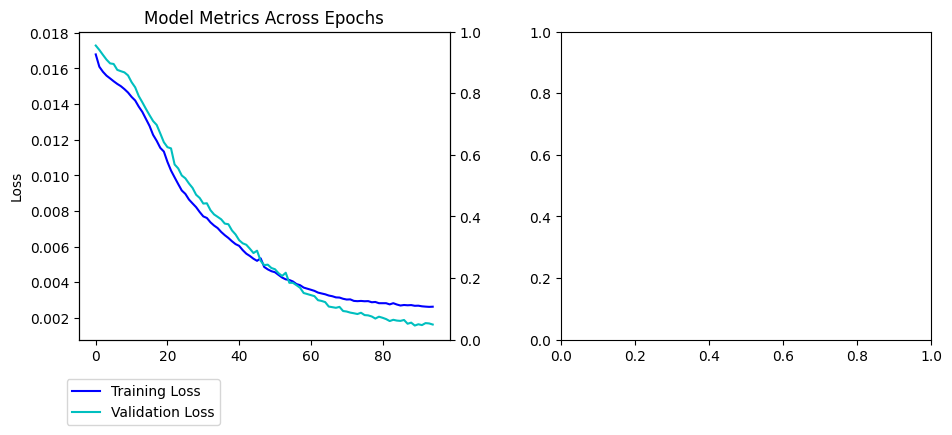

In [20]:
input_size = 4
hidden_size = 128
num_layers = 5
batch_size = 3
output_size = train_dataset.dataset.n_ahead

trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validLoader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = BasicLSTM(input_size, hidden_size, num_layers, output_size)

Trainer, mp = train_test_model(model, 0.001, trainLoader, validLoader, testLoader, EPOCHS=300, noPrint=False)
print(mp)

(12,) torch.Size([3, 12, 4]) torch.Size([24, 4])


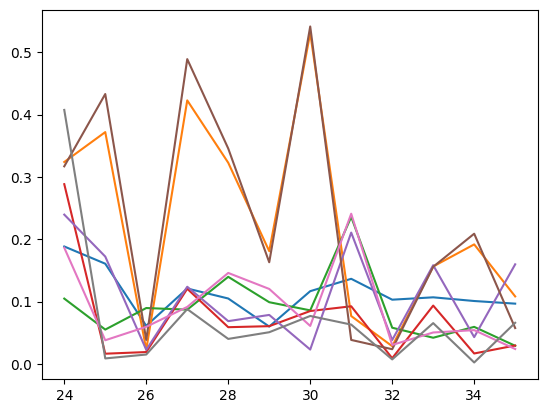

In [27]:
for X, Y in testLoader:
    X = X
    Y = Y
    pred = Trainer.model(X).detach().numpy()
    
    print(pred[0,:,0].shape, Y.shape, X[0].shape)
    
    # Assume Extension 
    y_range = range(len(X[0]), len(X[0])+validLoader.dataset.dataset.n_ahead)

    
    # plt.plot(X[0,:].detach().cpu())
    plt.plot(y_range, pred[0,:])
    
    plt.plot(y_range, Y[0,:])
    
    # plt.legend(["X", "Prediction", "Actual"])
    
    break

In [13]:
for x, y in trainLoader:
    print(x.shape, y.shape)
    break


torch.Size([3, 24, 4]) torch.Size([3, 12, 3])


In [11]:
len(testLoader)

60

In [9]:
max((total.values).reshape(-1))

3.962974854046147

In [18]:
torch.save(Trainer.model.state_dict(), "models/EMG_P1.pt")